In [27]:
# Import Statements
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [28]:
# Reading in the CSV file from Kaggle (Credits to Paola Mazza) into a Pandas Data Frame
players_df = pd.read_csv("players.csv")

In [29]:
# Split the dataset based on values in the 'Position' column
defenders_df = players_df[players_df['position'] == 'DEF']
midfielders_df = players_df[players_df['position'] == 'MID']
forwards_df = players_df[players_df['position'] == 'FWD']
keepers_df = players_df[players_df['position'] == 'GKP']

In [30]:
# Preprocess the data within the Pandas Data Frame
def preprocess(position_df):
    processed_df = position_df.copy()
    processed_df = processed_df.drop_duplicates()
    
    return processed_df

# Defenders Data
processed_defenders_df = preprocess(defenders_df)

# Midfielders Data
processed_midfielders_df = preprocess(midfielders_df)

# Forwards Data
processed_forwards_df = preprocess(forwards_df)

# Keepers Data
processed_keepers_df = preprocess(keepers_df)

Top Features:
                Feature  Importance
4   ict_index_rank_type    0.345847
41       ict_index_rank    0.267532
30                  bps    0.210425
3   influence_rank_type    0.046960
11       influence_rank    0.043802
   ict_index_rank_type  ict_index_rank  bps  influence_rank_type  \
0                   63             628    0                   61   
1                  172             493    0                  173   
2                  214             470   12                  215   
3                  139             300   62                  134   
4                   47             172  259                   42   

   influence_rank  
0             623  
1             487  
2             473  
3             318  
4             110  


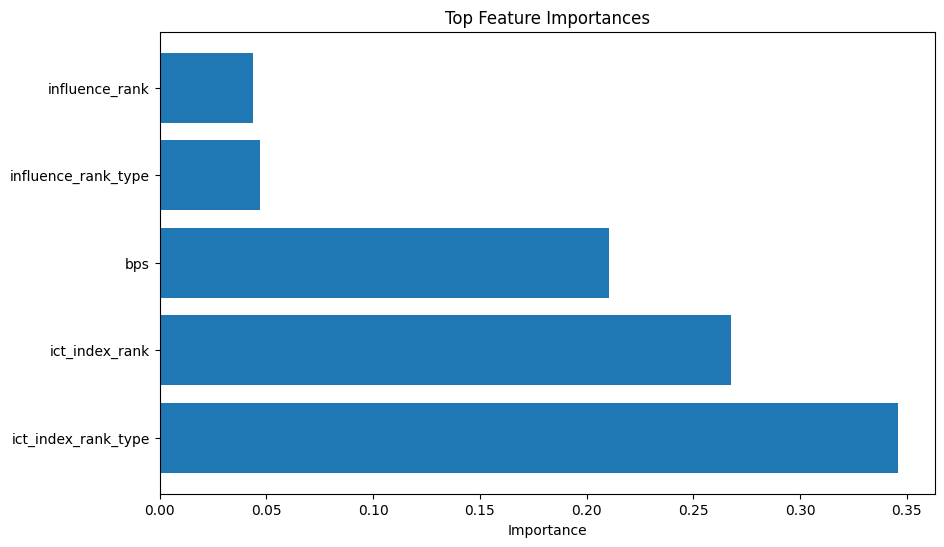

Top Features:
                 Feature  Importance
30                   bps    0.394653
12  points_per_game_rank    0.083248
22                 bonus    0.060048
37               minutes    0.056104
11        influence_rank    0.055163
   bps  points_per_game_rank  bonus  minutes  influence_rank
0    0                   635      0        0             623
1    0                   499      0        0             487
2   12                    55      0        1             473
3   62                   209      0      236             318
4  259                   100      4     1284             110


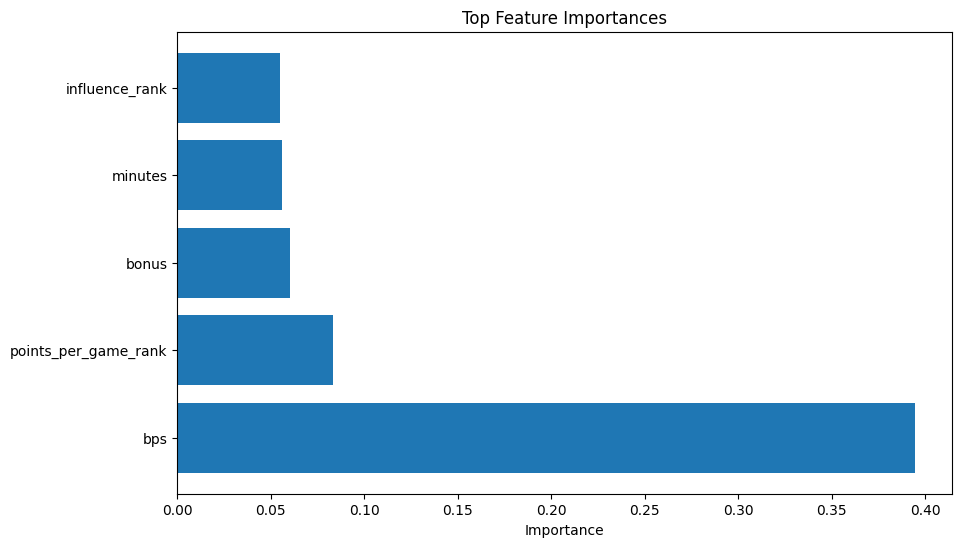

Top Features:
                      Feature  Importance
30                        bps    0.813998
25               clean_sheets    0.049153
12       points_per_game_rank    0.030845
20  points_per_game_rank_type    0.029119
22                      bonus    0.010044
   bps  clean_sheets  points_per_game_rank  points_per_game_rank_type  bonus
0    0             0                   635                         66      0
1    0             0                   499                        170      0
2   12             0                    55                         30      0
3   62             1                   209                         92      0
4  259             5                   100                         24      4


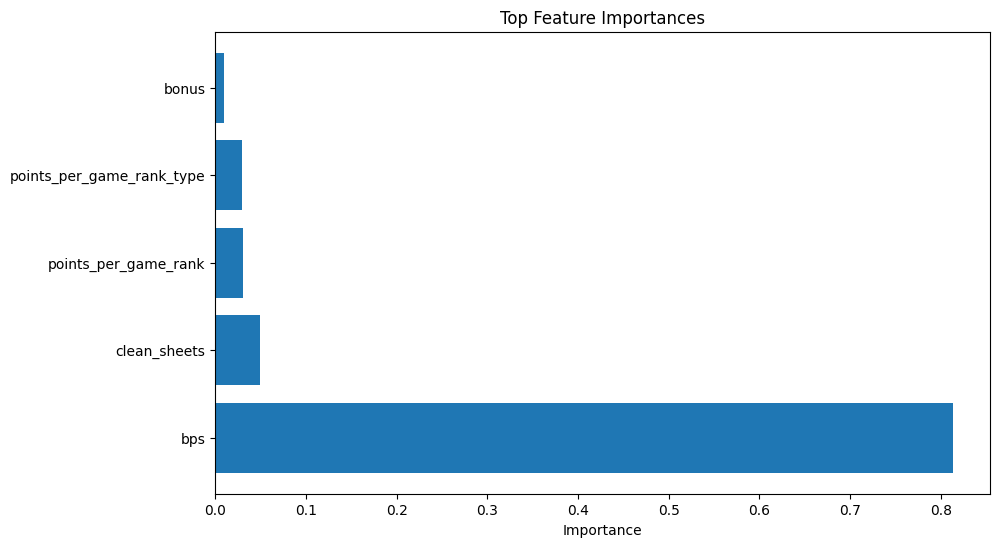

Top Features:
                Feature  Importance
37              minutes    0.174542
30                  bps    0.156437
16               starts    0.151663
31                saves    0.115193
4   ict_index_rank_type    0.086099
   minutes  bps  starts  saves  ict_index_rank_type
0        0    0       0      0                   63
1        0    0       0      0                  172
2        1   12       0      0                  214
3      236   62       2      0                  139
4     1284  259      14      0                   47


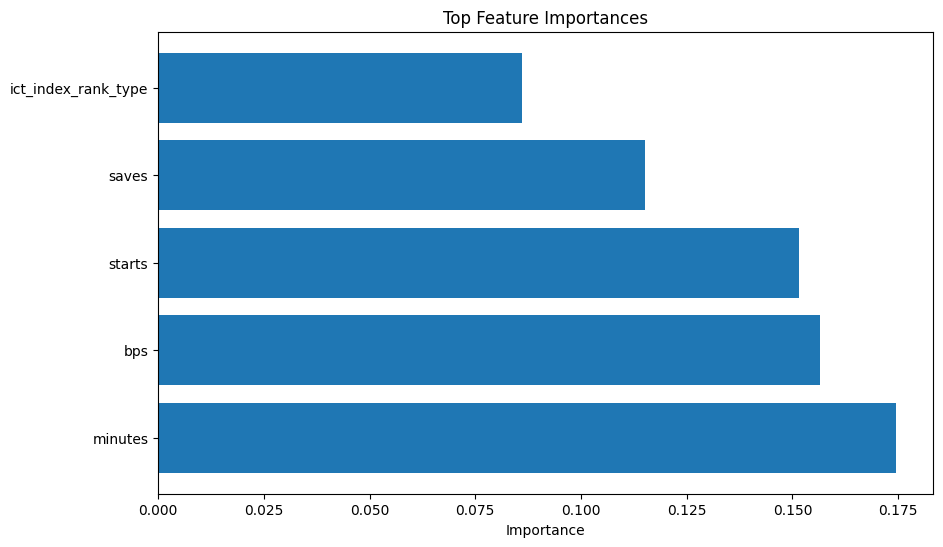

In [31]:
# Find the Top 5 Features for Predicting Players Score
def find_top_features(processed_df):
    copy_df = processed_df.copy()
    X = copy_df.drop(columns=['total_points'])
    y = processed_df['total_points']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    # Only need the top N features
    #print(f"Mean Squared Error: {mse}")

    feature_importances = model.feature_importances_
    top_features = X.columns[feature_importances.argsort()[::-1][:5]]
    
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    top_features_display = feature_importance_df.head(5)
    print("Top Features:")
    print(top_features_display)

    selected_features_df = players_df[top_features]
    print(selected_features_df.head())

    plt.figure(figsize=(10, 6))
    plt.barh(top_features_display['Feature'], top_features_display['Importance'])
    plt.xlabel('Importance')
    plt.title('Top Feature Importances')
    plt.show()
    
    return top_features

midfielder_features = find_top_features(processed_midfielders_df[processed_midfielders_df.select_dtypes(include=['int']).columns])
forward_features = find_top_features(processed_forwards_df[processed_forwards_df.select_dtypes(include=['int']).columns])
defender_features = find_top_features(processed_defenders_df[processed_defenders_df.select_dtypes(include=['int']).columns])
keeper_features = find_top_features(processed_keepers_df[processed_keepers_df.select_dtypes(include=['int']).columns])

In [32]:
def train_rf_model(df, position, features_used):
    X = df[features_used].copy()
    y = df['total_points']  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    mse = mean_squared_error(y_test, rf_model.predict(X_test))
    print(f'Mean Squared Error for {position}: {mse}')

    return rf_model

# Train Random Forest models for each position
rf_keepers = train_rf_model(processed_keepers_df, "GKP", keeper_features)
rf_defenders = train_rf_model(processed_defenders_df, "DEF", defender_features)
rf_midfielders = train_rf_model(processed_midfielders_df, "MID", midfielder_features)
rf_forwards = train_rf_model(processed_forwards_df, "FWD", forward_features)

Mean Squared Error for GKP: 29.648866666666663
Mean Squared Error for DEF: 11.673292000000002
Mean Squared Error for MID: 43.977289552238815
Mean Squared Error for FWD: 29.897395


In [33]:
# Assuming you have selected DataFrames for each position: selected_keepers_df, selected_defenders_df, selected_midfielders_df, selected_forwards_df

# Make predictions for each position
predicted_keepers = rf_keepers.predict(processed_keepers_df[keeper_features])
predicted_defenders = rf_defenders.predict(processed_defenders_df[defender_features])
predicted_midfielders = rf_midfielders.predict(processed_midfielders_df[midfielder_features])
predicted_forwards = rf_forwards.predict(processed_forwards_df[forward_features])

# Add the predicted total points to the original DataFrames
processed_keepers_df['predicted_points'] = predicted_keepers
processed_defenders_df['predicted_points'] = predicted_defenders
processed_midfielders_df['predicted_points'] = predicted_midfielders
processed_forwards_df['predicted_points'] = predicted_forwards

# Display the results for each position
print("Goalkeepers:")
print(processed_keepers_df[['name', 'predicted_points']].nlargest(2, 'predicted_points'))

print("\nDefenders:")
print(processed_defenders_df[['name', 'predicted_points']].nlargest(5, 'predicted_points'))

print("\nMidfielders:")
print(processed_midfielders_df[['name', 'predicted_points']].nlargest(5, 'predicted_points'))

print("\nForwards:")
print(processed_forwards_df[['name', 'predicted_points']].nlargest(3, 'predicted_points'))


Goalkeepers:
                      name  predicted_points
383  Alisson Ramses Becker             67.24
692      Guglielmo Vicario             67.19

Defenders:
                       name  predicted_points
382  Trent Alexander-Arnold             85.06
562         Kieran Trippier             83.43
18           William Saliba             71.65
679             Pedro Porro             69.92
25      Oleksandr Zinchenko             67.64

Midfielders:
               name  predicted_points
400   Mohamed Salah            108.96
688   Son Heung-min            108.96
17      Bukayo Saka            101.89
706    Jarrod Bowen             97.07
544  Anthony Gordon             85.94

Forwards:
                name  predicted_points
61     Ollie Watkins             99.73
474   Erling Haaland             91.36
95   Dominic Solanke             89.64


In [34]:
def train_rf_model(df, position):
    X = df.copy()
    y = df['total_points']  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        # Add other parameters to tune
    }

    # Create RandomForestRegressor
    rf_model = RandomForestRegressor()

    # Perform grid search
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Train a new model with the best parameters
    best_rf_model = RandomForestRegressor(**best_params)
    best_rf_model.fit(X_train, y_train)

    # Evaluate the model
    mse = mean_squared_error(y_test, best_rf_model.predict(X_test))
    print(f'Best {position} Mean Squared Error: {mse}')
    
    return best_rf_model
    
# Train Random Forest models for each position
rf_keepers = train_rf_model(processed_keepers_df[processed_keepers_df.select_dtypes(include=['int']).columns], "GKP")
rf_defenders = train_rf_model(processed_defenders_df[processed_defenders_df.select_dtypes(include=['int']).columns], "DEF")
rf_midfielders = train_rf_model(processed_midfielders_df[processed_midfielders_df.select_dtypes(include=['int']).columns], "MID")
rf_forwards = train_rf_model(processed_forwards_df[processed_forwards_df.select_dtypes(include=['int']).columns], "FWD")

Best GKP Mean Squared Error: 16.019822222222224
Best DEF Mean Squared Error: 0.25455399999999995
Best MID Mean Squared Error: 13.104041791044773
Best FWD Mean Squared Error: 31.890839999999997


In [35]:
# Make predictions for each position
predicted_keepers = rf_keepers.predict(processed_keepers_df[processed_keepers_df.select_dtypes(include=['int']).columns])
predicted_defenders = rf_defenders.predict(processed_defenders_df[processed_defenders_df.select_dtypes(include=['int']).columns])
predicted_midfielders = rf_midfielders.predict(processed_midfielders_df[processed_midfielders_df.select_dtypes(include=['int']).columns])
predicted_forwards = rf_forwards.predict(processed_forwards_df[processed_forwards_df.select_dtypes(include=['int']).columns])

# Add the predicted total points to the original DataFrames
processed_keepers_df['predicted_points'] = predicted_keepers
processed_defenders_df['predicted_points'] = predicted_defenders
processed_midfielders_df['predicted_points'] = predicted_midfielders
processed_forwards_df['predicted_points'] = predicted_forwards

# Display the results for each position
print("Goalkeepers:")
print(processed_keepers_df[['name', 'predicted_points']].nlargest(2, 'predicted_points'))

print("\nDefenders:")
print(processed_defenders_df[['name', 'predicted_points']].nlargest(5, 'predicted_points'))

print("\nMidfielders:")
print(processed_midfielders_df[['name', 'predicted_points']].nlargest(5, 'predicted_points'))

print("\nForwards:")
print(processed_forwards_df[['name', 'predicted_points']].nlargest(3, 'predicted_points'))

Goalkeepers:
            name  predicted_points
355   Bernd Leno             68.24
522  André Onana             66.84

Defenders:
                       name  predicted_points
382  Trent Alexander-Arnold             80.93
562         Kieran Trippier             79.88
679             Pedro Porro             70.47
18           William Saliba             70.42
25      Oleksandr Zinchenko             68.16

Midfielders:
               name  predicted_points
688   Son Heung-min            111.66
400   Mohamed Salah            108.36
706    Jarrod Bowen            102.38
17      Bukayo Saka             94.68
544  Anthony Gordon             88.66

Forwards:
                name  predicted_points
61     Ollie Watkins            100.56
95   Dominic Solanke             89.34
474   Erling Haaland             89.14
